In [1]:
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

class EfficientNetWithSepConv(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Load the base model
        self.base = timm.create_model("efficientnet_b0", pretrained=True, features_only=False)
        
        # Extract the features before the classifier
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        
        # Define input features for the separable convolution
        in_features = 1280
        
        self.sep_conv = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, groups=in_features, padding=1),
            nn.Conv2d(in_features, 256, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Use the forward method without accessing .features
        x = self.base(x)
        # At this point, x should be the output from the EfficientNet's feature extractor
        x = self.sep_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define class names
class_names = ["cloudy", "desert", "green_area", "water"]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = EfficientNetWithSepConv(num_classes=4).to(device)
model_path = "final_model.pth"  # Adjust path if saved elsewhere, e.g., "SatelliteImageProject/final_model.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model weights not found at {model_path}. Please ensure the model is saved.")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded successfully from 'final_model.pth'")


/home/rjaswal1634/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Model loaded successfully from 'final_model.pth'


Satellite Image Classifier
-------------------------
Note: If your image is in the 'data' folder, use the full path, e.g., 'SatelliteImageProject/data/green_area/Forest_4.jpg'


Enter the path to your satellite image (or 'quit' to exit):  water.jpeg


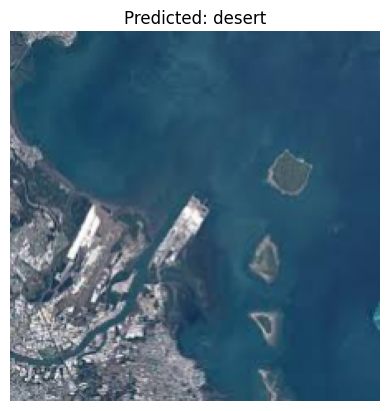


Predicted Class: desert
Confidence Scores:
cloudy: 0.19%
desert: 99.78%
green_area: 0.00%
water: 0.03%


Enter the path to your satellite image (or 'quit' to exit):  images2.jpg


Error: Image not found at images2.jpg or SatelliteImageProject/images2.jpg
Please try again with a valid image path.


Enter the path to your satellite image (or 'quit' to exit):  image2.jpg


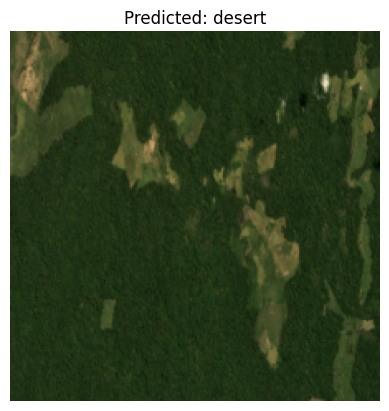


Predicted Class: desert
Confidence Scores:
cloudy: 0.01%
desert: 98.72%
green_area: 1.27%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  dessert.jpeg


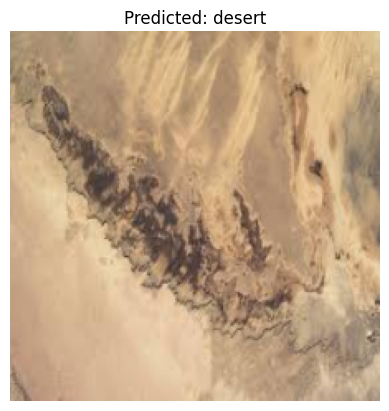


Predicted Class: desert
Confidence Scores:
cloudy: 0.02%
desert: 99.98%
green_area: 0.00%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  images.jpeg


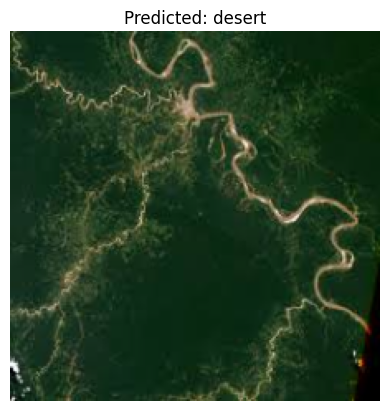


Predicted Class: desert
Confidence Scores:
cloudy: 0.00%
desert: 100.00%
green_area: 0.00%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  data/cloudy/train_12.jpg


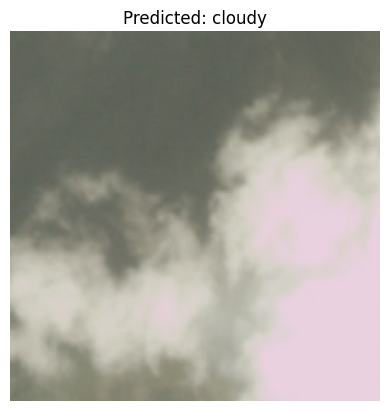


Predicted Class: cloudy
Confidence Scores:
cloudy: 99.99%
desert: 0.00%
green_area: 0.00%
water: 0.01%


Enter the path to your satellite image (or 'quit' to exit):  data/cloudy/train_534.jpg


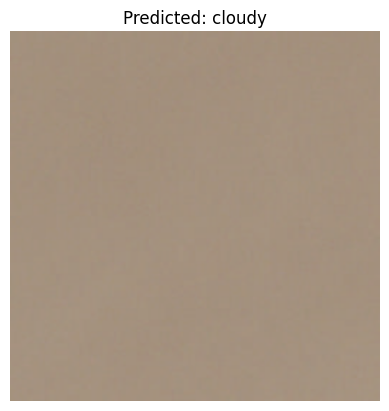


Predicted Class: cloudy
Confidence Scores:
cloudy: 100.00%
desert: 0.00%
green_area: 0.00%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  data/desert/desert(1).jpg


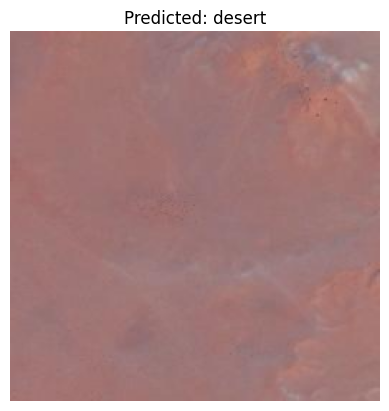


Predicted Class: desert
Confidence Scores:
cloudy: 0.02%
desert: 99.98%
green_area: 0.00%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  data/green_area/Forest_2/jpg


Error: Image not found at data/green_area/Forest_2/jpg or SatelliteImageProject/data/green_area/Forest_2/jpg
Please try again with a valid image path.


Enter the path to your satellite image (or 'quit' to exit):  data/green_area/Forest_2.jpg


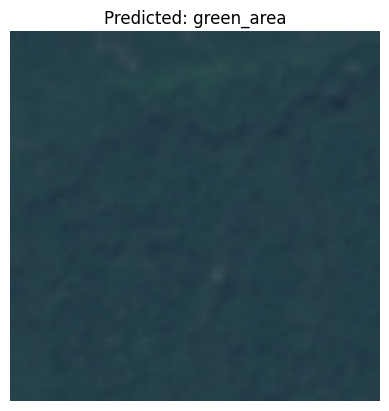


Predicted Class: green_area
Confidence Scores:
cloudy: 0.00%
desert: 0.00%
green_area: 99.98%
water: 0.02%


Enter the path to your satellite image (or 'quit' to exit):  quit


Exiting...


In [9]:
# Define the same transform as training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess a Google image
google_image_path = "images.jpeg"  # Replace with your image path
image = Image.open(google_image_path).convert("RGB")
image_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Predict
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.softmax(output, dim=1)
    predicted_idx = torch.argmax(output, dim=1).item()
    predicted_class = class_names[predicted_idx]
    print(f"Predicted class: {predicted_class}")
    print(f"Probabilities: {probabilities.cpu().numpy()[0]}")

Predicted class: desert
Probabilities: [9.8240122e-08 9.9999976e-01 6.8300039e-08 1.7062101e-08]


In [4]:
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
# Define the test dataset and loader
print("starting")
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_folder = "processed_data/test"  # Adjust path as needed
if not os.path.exists(test_folder):
    raise FileNotFoundError(f"Test folder not found at {test_folder}. Please ensure the folder exists.")

test_dataset = ImageFolder(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Collect predictions and labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute overall accuracy
total = len(all_labels)
correct = sum(np.array(all_preds) == np.array(all_labels))
overall_accuracy = 100 * correct / total
print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

# Generate classification report
print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Compute per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_correct = sum((np.array(all_labels) == i) & (np.array(all_preds) == i))
    class_total = sum(np.array(all_labels) == i)
    per_class_accuracy[class_name] = 100 * class_correct / class_total
    print(f"Accuracy for {class_name}: {per_class_accuracy[class_name]:.2f}%")

# Optionally save results to a file
with open("test_results.txt", "w") as f:
    f.write(f"Overall Test Accuracy: {overall_accuracy:.2f}%\n\n")
    f.write("Classification Report on Test Set:\n")
    f.write(classification_report(all_labels, all_preds, target_names=class_names))
    f.write("\nPer-Class Accuracy:\n")
    for class_name, acc in per_class_accuracy.items():
        f.write(f"Accuracy for {class_name}: {acc:.2f}%\n")
print("Results saved to 'test_results.txt'")

starting

Overall Test Accuracy: 100.00%

Classification Report on Test Set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       150
      desert       1.00      1.00      1.00       249
  green_area       1.00      1.00      1.00       150
       water       1.00      1.00      1.00       150

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699

Accuracy for cloudy: 100.00%
Accuracy for desert: 100.00%
Accuracy for green_area: 100.00%
Accuracy for water: 100.00%
Results saved to 'test_results.txt'


In [13]:
pip install torchviz

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
from torchviz import make_dot
import torch

# Define your model
model = EfficientNetWithSepConv(num_classes=4).to(device)

# Create a dummy input (batch size 1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Perform a forward pass to build the computation graph
output = model(dummy_input)

# Generate and save the graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("efficientnet_model", format="png", cleanup=True)

print("Model architecture saved as 'efficientnet_model.png'")

Model architecture saved as 'efficientnet_model.png'


In [5]:
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, ConcatDataset
import torch
import torchvision.transforms as transforms  # Explicitly import transforms
import os

# Define the transformation for validation and test data
print("Starting")
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define paths to train, validation, and test folders
train_folder = "processed_data/train"
val_folder = "processed_data/val"
test_folder = "processed_data/test"

# Check if folders exist
for folder in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder not found at {folder}. Please ensure the folder exists.")

# Load datasets
train_dataset = ImageFolder(train_folder, transform=test_transform)
val_dataset = ImageFolder(val_folder, transform=test_transform)
test_dataset = ImageFolder(test_folder, transform=test_transform)

# Verify the initial 80/10/10 split
total_samples = len(train_dataset) + len(val_dataset) + len(test_dataset)
train_percent = 100 * len(train_dataset) / total_samples
val_percent = 100 * len(val_dataset) / total_samples
test_percent = 100 * len(test_dataset) / total_samples
print(f"Total samples: {total_samples}")
print(f"Train: {len(train_dataset)} samples ({train_percent:.2f}%)")
print(f"Validation: {len(val_dataset)} samples ({val_percent:.2f}%)")
print(f"Test: {len(test_dataset)} samples ({test_percent:.2f}%)")

# Combine validation and test datasets for the new 80/20 split
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

# Verify the new 80/20 split
combined_test_percent = 100 * len(combined_test_dataset) / total_samples
print(f"\nNew Split Verification:")
print(f"Train: {len(train_dataset)} samples ({train_percent:.2f}%)")
print(f"Combined Test (Val + Test): {len(combined_test_dataset)} samples ({combined_test_percent:.2f}%)")

# Collect predictions and labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in combined_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute overall accuracy
total = len(all_labels)
correct = sum(np.array(all_preds) == np.array(all_labels))
overall_accuracy = 100 * correct / total
print(f"\nOverall Test Accuracy (Combined Val + Test): {overall_accuracy:.2f}%")

# Generate classification report
class_names = val_dataset.classes  # Assuming classes are consistent across datasets
print("\nClassification Report on Combined Validation + Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Compute per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_correct = sum((np.array(all_labels) == i) & (np.array(all_preds) == i))
    class_total = sum(np.array(all_labels) == i)
    per_class_accuracy[class_name] = 100 * class_correct / class_total if class_total > 0 else 0
    print(f"Accuracy for {class_name}: {per_class_accuracy[class_name]:.2f}%")

# Save results to a file
with open("combined_test_results.txt", "w") as f:
    f.write(f"Overall Test Accuracy (Combined Val + Test): {overall_accuracy:.2f}%\n\n")
    f.write("Classification Report on Combined Validation + Test Set:\n")
    f.write(classification_report(all_labels, all_preds, target_names=class_names))
    f.write("\nPer-Class Accuracy:\n")
    for class_name, acc in per_class_accuracy.items():
        f.write(f"Accuracy for {class_name}: {acc:.2f}%\n")
print("Results saved to 'combined_test_results.txt'")

Starting
Total samples: 6377
Train: 4974 samples (78.00%)
Validation: 704 samples (11.04%)
Test: 699 samples (10.96%)

New Split Verification:
Train: 4974 samples (78.00%)
Combined Test (Val + Test): 1403 samples (22.00%)

Overall Test Accuracy (Combined Val + Test): 99.86%

Classification Report on Combined Validation + Test Set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       300
      desert       1.00      1.00      1.00       503
  green_area       1.00      1.00      1.00       300
       water       1.00      1.00      1.00       300

    accuracy                           1.00      1403
   macro avg       1.00      1.00      1.00      1403
weighted avg       1.00      1.00      1.00      1403

Accuracy for cloudy: 100.00%
Accuracy for desert: 99.80%
Accuracy for green_area: 99.67%
Accuracy for water: 100.00%
Results saved to 'combined_test_results.txt'


In [6]:
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, ConcatDataset
import torch
import torchvision.transforms as transforms
import os

# Define the transformation for validation and test data
print("Starting")
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define paths to train, validation, and test folders
train_folder = "processed_data/train"
val_folder = "processed_data/val"
test_folder = "processed_data/test"

# Check if folders exist
for folder in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder not found at {folder}. Please ensure the folder exists.")

# Load datasets
train_dataset = ImageFolder(train_folder, transform=test_transform)
val_dataset = ImageFolder(val_folder, transform=test_transform)
test_dataset = ImageFolder(test_folder, transform=test_transform)

# Verify the initial 80/10/10 split
total_samples = len(train_dataset) + len(val_dataset) + len(test_dataset)
train_percent = 100 * len(train_dataset) / total_samples
val_percent = 100 * len(val_dataset) / total_samples
test_percent = 100 * len(test_dataset) / total_samples
print(f"Total samples: {total_samples}")
print(f"Train: {len(train_dataset)} samples ({train_percent:.2f}%)")
print(f"Validation: {len(val_dataset)} samples ({val_percent:.2f}%)")
print(f"Test: {len(test_dataset)} samples ({test_percent:.2f}%)")

# Combine validation and test datasets for the new 80/20 split
combined_test_dataset = ConcatDataset([val_dataset, test_dataset])
combined_test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

# Verify the new 80/20 split
combined_test_percent = 100 * len(combined_test_dataset) / total_samples
print(f"\nNew Split Verification:")
print(f"Train: {len(train_dataset)} samples ({train_percent:.2f}%)")
print(f"Combined Test (Val + Test): {len(combined_test_dataset)} samples ({combined_test_percent:.2f}%)")

# Collect predictions and labels for combined dataset
all_preds_combined = []
all_labels_combined = []
model.eval()
with torch.no_grad():
    for images, labels in combined_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_combined.extend(predicted.cpu().numpy())
        all_labels_combined.extend(labels.cpu().numpy())

# Compute overall accuracy for combined dataset
total = len(all_labels_combined)
correct = sum(np.array(all_preds_combined) == np.array(all_labels_combined))
overall_accuracy = 100 * correct / total
print(f"\nOverall Test Accuracy (Combined Val + Test): {overall_accuracy:.2f}%")

# Generate classification report for combined dataset
class_names = val_dataset.classes  # Assuming classes are consistent
print("\nClassification Report on Combined Validation + Test Set:")
print(classification_report(all_labels_combined, all_preds_combined, target_names=class_names))

# Compute confusion matrix for combined dataset
conf_matrix_combined = confusion_matrix(all_labels_combined, all_preds_combined)
print("\nConfusion Matrix (Combined Val + Test):")
print(conf_matrix_combined)

# Compute per-class accuracy for combined dataset
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_correct = sum((np.array(all_labels_combined) == i) & (np.array(all_preds_combined) == i))
    class_total = sum(np.array(all_labels_combined) == i)
    per_class_accuracy[class_name] = 100 * class_correct / class_total if class_total > 0 else 0
    print(f"Accuracy for {class_name}: {per_class_accuracy[class_name]:.2f}%")

# Optionally: Evaluate validation and test sets separately
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Validation set predictions
all_preds_val = []
all_labels_val = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_val.extend(predicted.cpu().numpy())
        all_labels_val.extend(labels.cpu().numpy())

# Test set predictions
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Confusion matrices for individual sets
conf_matrix_val = confusion_matrix(all_labels_val, all_preds_val)
conf_matrix_test = confusion_matrix(all_labels_test, all_preds_test)
print("\nConfusion Matrix (Validation Only):")
print(conf_matrix_val)
print("\nConfusion Matrix (Test Only):")
print(conf_matrix_test)

# Save results to a file
with open("combined_test_results_with_confusion.txt", "w") as f:
    f.write(f"Overall Test Accuracy (Combined Val + Test): {overall_accuracy:.2f}%\n\n")
    f.write("Classification Report on Combined Validation + Test Set:\n")
    f.write(classification_report(all_labels_combined, all_preds_combined, target_names=class_names))
    f.write("\nConfusion Matrix (Combined Val + Test):\n")
    f.write(str(conf_matrix_combined) + "\n")
    f.write("\nPer-Class Accuracy:\n")
    for class_name, acc in per_class_accuracy.items():
        f.write(f"Accuracy for {class_name}: {acc:.2f}%\n")
    f.write("\nConfusion Matrix (Validation Only):\n")
    f.write(str(conf_matrix_val) + "\n")
    f.write("\nConfusion Matrix (Test Only):\n")
    f.write(str(conf_matrix_test) + "\n")
print("Results saved to 'combined_test_results_with_confusion.txt'")

Starting
Total samples: 6377
Train: 4974 samples (78.00%)
Validation: 704 samples (11.04%)
Test: 699 samples (10.96%)

New Split Verification:
Train: 4974 samples (78.00%)
Combined Test (Val + Test): 1403 samples (22.00%)

Overall Test Accuracy (Combined Val + Test): 99.86%

Classification Report on Combined Validation + Test Set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       300
      desert       1.00      1.00      1.00       503
  green_area       1.00      1.00      1.00       300
       water       1.00      1.00      1.00       300

    accuracy                           1.00      1403
   macro avg       1.00      1.00      1.00      1403
weighted avg       1.00      1.00      1.00      1403


Confusion Matrix (Combined Val + Test):
[[300   0   0   0]
 [  1 502   0   0]
 [  0   0 299   1]
 [  0   0   0 300]]
Accuracy for cloudy: 100.00%
Accuracy for desert: 99.80%
Accuracy for green_area: 99.67%
Accuracy for water: 100.0